## ASTR777 Star and Planet Formation Problem Set 5
### Protoplanetary disk SED

Integrate a modified blackbody over all radii for an input surface density and temperature profile,
$$ F_\nu = \int_{R_{\rm min}}^{R_{\rm max}} B_\nu(T)\ \left[1-\exp(-\kappa_\nu\Sigma\,/\cos i)\right]\ \frac{2\pi r\, dr\cos i}{d^2}.$$

with power law forms for the dust opacity from Beckwith et al. 1990,
$$\kappa_\nu = \kappa_0\left(\frac{\nu}{\nu_0}\right)^\beta \equiv 10\left(\frac{\nu}{10^{12}{\rm Hz}}\right) {\rm cm^2/g},$$

and parameterized surface density, and temperature,
$$\Sigma(r) = \Sigma_1\left(\frac{r}{r_1}\right)^{-1} ~~~~~ T(r) = T_1\left(\frac{r}{r_1}\right)^{-q}.$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astropy import constants as c
%matplotlib inline

In [2]:
# blackbody
def Bnu(nu,T):
    return(2*c.h*nu**3 / c.c**2 * (np.exp(c.h*nu/(c.k_B*T)) - 1)**-1)

In [3]:
# simple addition here (could also use np.trapz or scipy modules for more precision)
# note imprecise nomenclature Fnu because it still needs to be divided by d^2 in au units
def integrate_disk(nu, r, T, Sigma, beta, incl):
    cosi = np.cos(incl * np.pi/180)
    Fnu = np.zeros(nu.size) * Bnu(1*u.Hz,1*u.K)
    for i in range(r.size-1):
        r0 = r[i]
        dr = r[i+1] - r0
        kappa_nu = 10 * (nu.value/1e12)**beta    # Beckwith dust opacity (cm2/g)
        tau_nu = kappa_nu * Sigma[i] / cosi
        Fnu += Bnu(nu, T[i]) * (1 - np.exp(-tau_nu))* 2 * np.pi * r0 * cosi * dr
    return Fnu

In [4]:
# correct for extinction based on Wang & Chen 2019
# inputs are wavelength in microns, flux in Jy, A_V = visual extinction in magnitudes
def extinct(wl, F, A_V):
    F_extincted = np.zeros(F.size)
    for i, wl1 in enumerate(wl):
        if wl1 < 1:
            Y = (1/wl1) - 1.82
            scale = 1.0 + 0.7499*Y - 0.1086*Y**2 - 0.08909*Y**3 + 0.02905*Y**4 + 0.01069*Y**5 + 0.001707*Y**6 - 0.001002*Y**7
        elif wl1 < 3:
            scale = 0.3722 / wl1**2.070
        else:
            scale = 0.0
        F_extincted[i] = F[i] / 10**(scale*A_V/2.5)   
    return F_extincted

In [5]:
def plotdata():
    fig = plt.figure(figsize=(8,5))
    ax = fig.add_subplot(111)

    ax.set_xlim(2e-1, 5e3)
    ax.set_ylim(5e-18, 2e-12)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'$\lambda$ ($\mu$m)', fontsize=14)
    ax.set_ylabel(r'$\nu F_\nu$ (W m$^{-2}$)', fontsize=14)
    
    # data
    wl_obs, Fnu_obs, sigsys, cal, ref = np.genfromtxt('aa_tau.txt', unpack=True)
    nu_obs = 3e-12 / wl_obs
    Fnu_sigma = np.sqrt(sigsys**2 + (cal*Fnu_obs)**2)
    ax.plot(wl_obs, nu_obs*Fnu_obs, 'ko', label='Observations')
    #ax.errorbar(wl_obs, nu_obs*Fnu_obs, yerr=nu_obs*Fnu_sigma, fmt='o', ecolor='black', elinewidth=0.5, mfc='black', ms=5, mec='None')

    x_labels = ['1','10','100','1000']
    x_loc = np.array([float(x) for x in x_labels])
    ax.set_xticks(x_loc)
    ax.set_xticklabels(x_labels)

    return fig, ax

### Flat disk SED, $T \propto r^{-3/4}$

Dust sublimation radius = 0.033 au


C:\Users\vdegu\anaconda3\lib\site-packages\astropy\units\quantity.py:611: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\vdegu\anaconda3\lib\site-packages\astropy\units\quantity.py:611: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


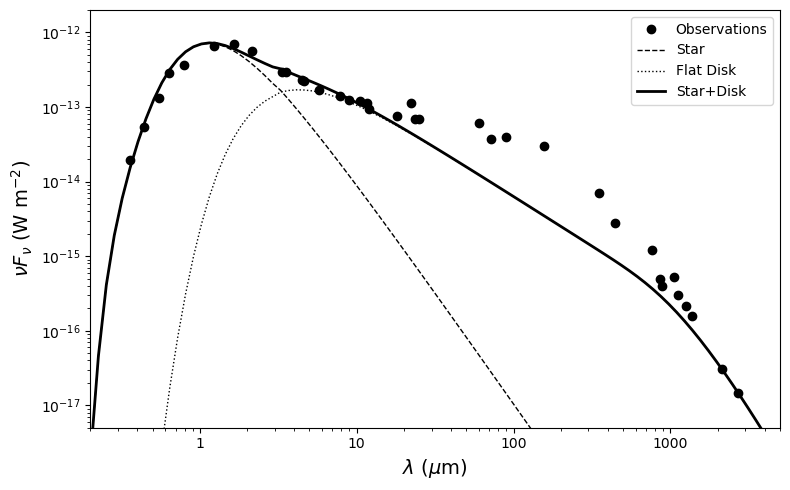

In [6]:
# luminosity and temperature of the star from Andrews et al. 2013
# note that I've increased the extinction from his value of 1.24 to fit the star SED
logT = 3.6085
logL = -0.059
A_V = 1.4
# disk inclination from Loomis et al. 2017
incl = 59
# distance from Gaia = 135pc
Gaia_parallax = 7.4255
d_pc = 1000/Gaia_parallax
d_au = d_pc * 2.06e5

# derived stellar radius (squared)
Rstar_sq = 10**logL * u.Lsun / (4*np.pi * c.sigma_sb * (10**logT * u.K)**4)
# stellar solid angle
Omega_star = (np.pi * Rstar_sq / (d_pc * u.pc)**2)

# dust sublimation radius (Kobayashi 2012)
Tsub = 2100
Rmin = (np.sqrt(Rstar_sq) * (10**logT / Tsub)**2 / u.au).decompose().value
print(f'Dust sublimation radius = {Rmin:5.3f} au')

# plot observations
fig, ax = plotdata()

# calculate SED from 0.1 microns to 1cm
wl = np.logspace(-1,4,100)  # microns
nu = (3e14 / wl) * u.Hz

# stellar SED = blackbody
Fnu_star = (Bnu(nu, 10**logT*u.K) * Omega_star / u.Jy).decompose()
Fnu_star_extincted = extinct(wl, Fnu_star, A_V)
ax.plot(wl, 3e-12*Fnu_star_extincted/wl, color='black', lw=1, ls='--', label='Star')

# integrate disk over annuli from Rmin to Rmax
Rmax = 100   # au
r = np.logspace(np.log10(Rmin), np.log10(Rmax), 1000)

# dust opacity spectral index, fixed following problem set
beta = 1

# flat disk q = 0.75
T1 = 110 * u.K  # best value for flat disk
T = T1 / r**0.75

# play around with surface density normalization to fit the millimeter points
# note that its large because the disk is so cold
Sigma1 = 12                # g/cm2
Sigma = Sigma1 / r

Fnu_disk = (integrate_disk(nu, r, T, Sigma, beta, incl) / d_au**2 / u.Jy).decompose()
Fnu_disk_extincted = extinct(wl, Fnu_disk, A_V)
ax.plot(wl, 3e-12*Fnu_disk_extincted/wl, color='black', lw=1, ls=':', label='Flat Disk')
ax.plot(wl, 3e-12*(Fnu_star_extincted + Fnu_disk_extincted)/wl, color='black', lw=2, ls='-', label='Star+Disk')
    
ax.legend()
fig.tight_layout(rect=[0.0,0.0,1.0,1.0])
plt.savefig('flat_disk_SED.pdf')

### Add a second temperature component to account for the flaring

C:\Users\vdegu\anaconda3\lib\site-packages\astropy\units\quantity.py:611: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\vdegu\anaconda3\lib\site-packages\astropy\units\quantity.py:611: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\vdegu\anaconda3\lib\site-packages\astropy\units\quantity.py:611: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


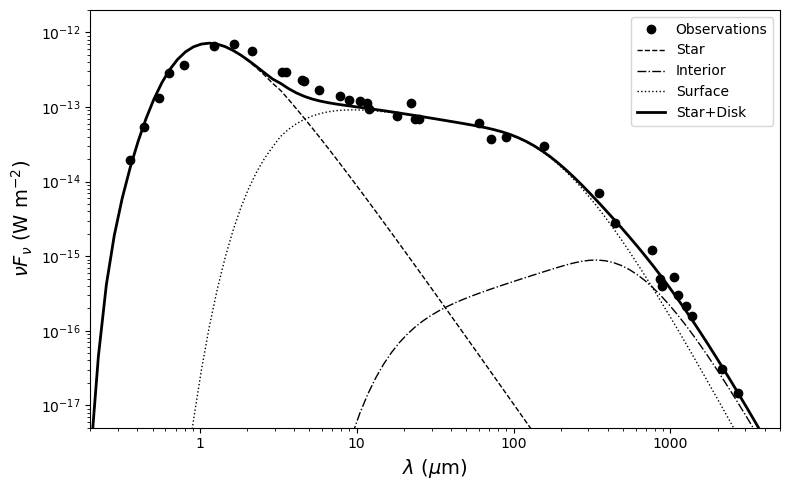

In [7]:
fig, ax = plotdata()
ax.plot(wl, 3e-12*Fnu_star_extincted/wl, color='black', lw=1, ls='--', label='Star')

# interior, play around with temperature and surface density normalization (power law is from Chiang & Goldreich)
T1 = 40 * u.K
T = T1 / r**(3/7)
Sigma_interior = 6                 # g/cm2
Fnu_disk1 = (integrate_disk(nu, r, T, Sigma_interior/r, beta, incl) / d_au**2 / u.Jy).decompose()
Fnu_disk1_extincted = extinct(wl, Fnu_disk1, A_V)

# play around with the normalization again; I give the power law which is actually shallower than CG97 because the SED is flatter
Tflare = 150 * u.K
T = Tflare / r**0.55
Sigma_surf = 0.5               # g/cm2
Fnu_disk2 = (integrate_disk(nu, r, T, Sigma_surf/r, beta, incl) / d_au**2 / u.Jy).decompose()
Fnu_disk2_extincted = extinct(wl, Fnu_disk2, A_V)

ax.plot(wl, 3e-12*Fnu_disk1_extincted/wl, color='black', lw=1, ls='-.', label='Interior')
ax.plot(wl, 3e-12*Fnu_disk2_extincted/wl, color='black', lw=1, ls=':', label='Surface')
ax.plot(wl, 3e-12*(Fnu_star_extincted + Fnu_disk1_extincted + Fnu_disk2_extincted)/wl, color='black', lw=2, ls='-', label='Star+Disk')
    
ax.legend()
fig.tight_layout(rect=[0.0,0.0,1.0,1.0])
plt.savefig('flared_disk_SED.pdf')

### Change dust opacity index and radial range of integration

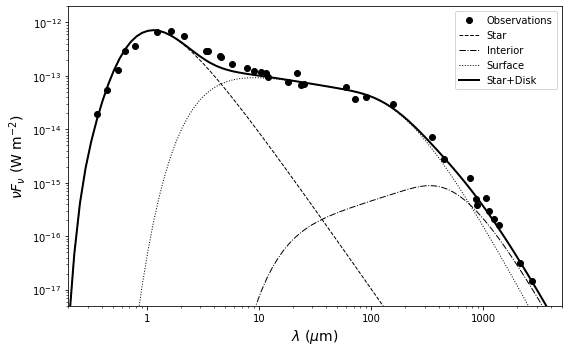

In [74]:
beta = 1
Rmin = 0.03  # au
Rmax = 100  # au
r = np.logspace(np.log10(Rmin), np.log10(Rmax), 1000)

fig, ax = plotdata()
ax.plot(wl, 3e-12*Fnu_star_extincted/wl, color='black', lw=1, ls='--', label='Star')

# interior, play around with temperature and surface density normalization (power law is from Chiang & Goldreich)
T1 = 40 * u.K
T = T1 / r**(3/7)
Sigma_interior = 6                 # g/cm2
Fnu_disk1 = (integrate_disk(nu, r, T, Sigma_interior/r, beta, incl) / d_au**2 / u.Jy).decompose()
Fnu_disk1_extincted = extinct(wl, Fnu_disk1, A_V)

# play around with the normalization again; I give the power law which is actually shallower than CG97 because the SED is flatter
Tflare = 150 * u.K
T = Tflare / r**0.55
Sigma_surf = 0.5               # g/cm2
Fnu_disk2 = (integrate_disk(nu, r, T, Sigma_surf/r, beta, incl) / d_au**2 / u.Jy).decompose()
Fnu_disk2_extincted = extinct(wl, Fnu_disk2, A_V)

ax.plot(wl, 3e-12*Fnu_disk1_extincted/wl, color='black', lw=1, ls='-.', label='Interior')
ax.plot(wl, 3e-12*Fnu_disk2_extincted/wl, color='black', lw=1, ls=':', label='Surface')
ax.plot(wl, 3e-12*(Fnu_star_extincted + Fnu_disk1_extincted + Fnu_disk2_extincted)/wl, color='black', lw=2, ls='-', label='Star+Disk')
    
ax.legend()
fig.tight_layout(rect=[0.0,0.0,1.0,1.0])

#### beta steepens the SED at millimeter wavelengths (where disk is optically thin)
#### Rmin makes a dip in the MIR part of the SED (transition disks); note it can't be smaller than 0.03 au because dust would evaporate!
#### Rmax affects the outer disk but if it is > 100au, it has very little effect (lots of area but very cold and little emission)

### Simple ring model (no strong effect!)

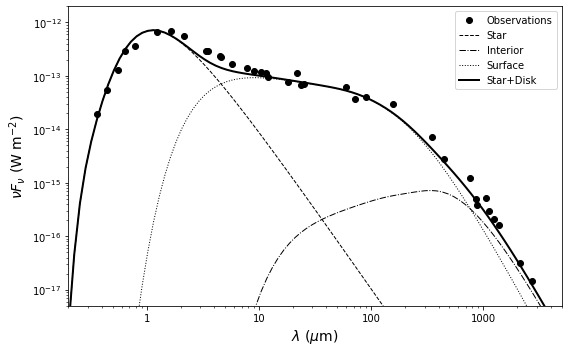

In [81]:
beta = 1
Rmin = 0.03  # au
Rmax = 100  # au
r = np.logspace(np.log10(Rmin), np.log10(Rmax), 1000)

ring = np.where(np.abs(r-20) < 5)[0]

fig, ax = plotdata()
ax.plot(wl, 3e-12*Fnu_star_extincted/wl, color='black', lw=1, ls='--', label='Star')

# interior, play around with temperature and surface density normalization (power law is from Chiang & Goldreich)
T1 = 40 * u.K
T = T1 / r**(3/7)
Sigma_interior = 6                 # g/cm2
Sigma = Sigma_interior/r
Sigma[ring] = 0
Fnu_disk1 = (integrate_disk(nu, r, T, Sigma, beta, incl) / d_au**2 / u.Jy).decompose()
Fnu_disk1_extincted = extinct(wl, Fnu_disk1, A_V)

# play around with the normalization again; I give the power law which is actually shallower than CG97 because the SED is flatter
Tflare = 150 * u.K
T = Tflare / r**0.55
Sigma_surf = 0.5               # g/cm2
Sigma = Sigma_surf/r
Sigma[ring] = 0
Fnu_disk2 = (integrate_disk(nu, r, T, Sigma, beta, incl) / d_au**2 / u.Jy).decompose()
Fnu_disk2_extincted = extinct(wl, Fnu_disk2, A_V)

ax.plot(wl, 3e-12*Fnu_disk1_extincted/wl, color='black', lw=1, ls='-.', label='Interior')
ax.plot(wl, 3e-12*Fnu_disk2_extincted/wl, color='black', lw=1, ls=':', label='Surface')
ax.plot(wl, 3e-12*(Fnu_star_extincted + Fnu_disk1_extincted + Fnu_disk2_extincted)/wl, color='black', lw=2, ls='-', label='Star+Disk')
    
ax.legend()
fig.tight_layout(rect=[0.0,0.0,1.0,1.0])